# Projet simulation logicielle
* *Rhouch Oussama*
* *Cherki Inssaf*

##### Load packages

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import librosa
import librosa.display
from sklearn import preprocessing

##### Load clean voice data

In [16]:
clean_audio, clean_rate = librosa.load('data/clean/dev-clean/2086/149214/2086-149214-0001.flac')

##### Plot the clean voice data

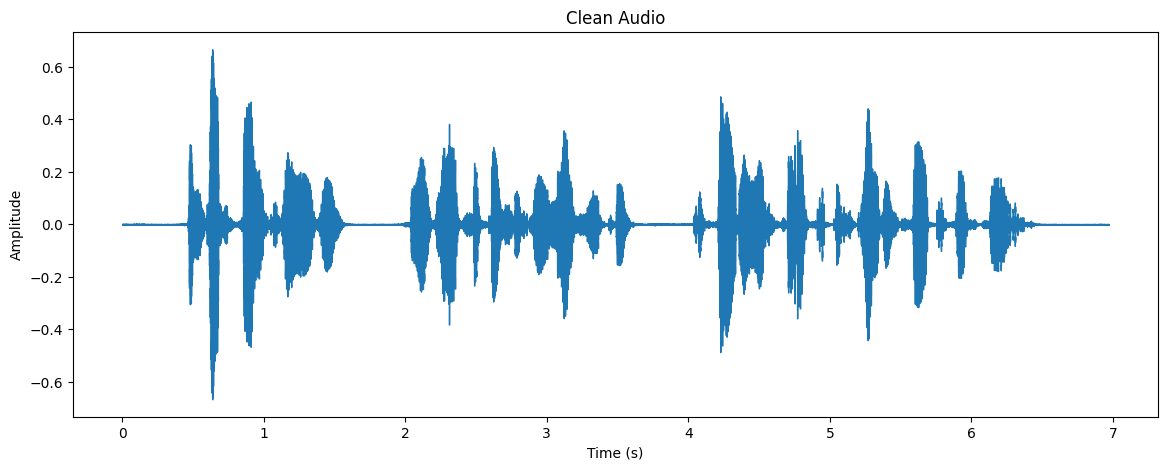

In [18]:
plt.figure(figsize=(14, 5))
librosa.display.waveshow(clean_audio, sr=clean_rate)
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('Clean Audio')
plt.show()

##### Load the noise data

In [20]:
noise_audio, noise_rate = librosa.load('data/noise/babble_16k.wav')

##### Plot the noise data

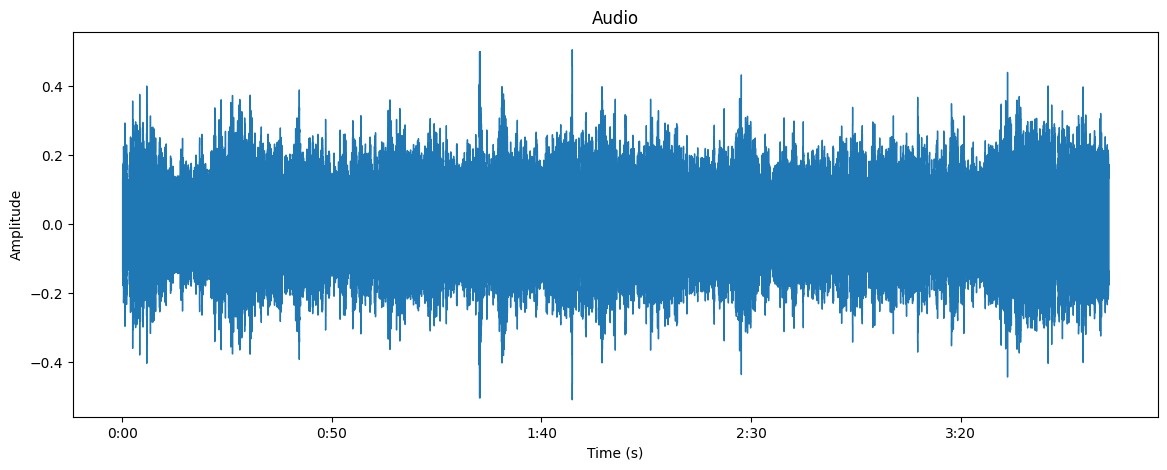

In [21]:
plt.figure(figsize=(14, 5))
librosa.display.waveshow(audio_data, sr=sample_rate)
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('Audio')
plt.show()

In [22]:
noise_norm = preprocessing.normalize([noise_audio])
voice_norm = preprocessing.normalize([clean_audio[:len(noise_audio)]])
S = librosa.stft(noise_norm[0])
Sdb = librosa.amplitude_to_db(abs(S))
plt.figure(figsize=(14, 5))
librosa.display.specshow(Sdb, sr=clean_audio, x_axis='time', y_axis='hz')
plt.colorbar()

ValueError: operands could not be broadcast together with shapes (1025,) (153689,) 

<Figure size 1400x500 with 0 Axes>